# 9. Automated Machine Learning 

This notebook contains some basics for autoML using CapyMOA:

* Implement a custom model selection procedure using CapyMOA.
* Perform hyperparameter optimization, and model selection using CapyMOA's AutoML
  features.

---

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [16]:
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier,
    StreamingRandomPatches,
    LeveragingBagging
)
from capymoa.datasets import Electricity, RBFm_100k
from capymoa.stream.generator import RandomTreeGenerator, SEA
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift

from capymoa.automl import BanditClassifier, SuccessiveHalvingClassifier, EpsilonGreedy

# Setup the data streams for our experiments:
stream = Electricity()
drift_stream = DriftStream(
    moa_stream=ConceptDriftStream(),
    CLI="""
    -s (generators.AgrawalGenerator -f 1) 
    -d (ConceptDriftStream 
        -s (generators.AgrawalGenerator -f 2)
        -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) 
        -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0)
        -p 20000 -w 0) 
    -p 10000 
    -w 0
""",
)

In [3]:
def print_summary(label: str, results):
    print(
        f"{label.ljust(10)} Cumulative accuracy = {results.accuracy():.2f}, "
        f"wall-clock time: {results.wallclock():.3f}"
    )

## 9.1 Custom Model Selection

In this section we manually define a method to select the best model based on
its accuracy on a given stream. First we define a list of models to be tried
and then we iterate over the stream to train and evaluate each model. The
model with the highest accuracy is selected as the best model.

In [4]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    best_accuracy = 0  # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=stream,
            learner=model,
            window_size=window_size,
            max_instances=max_instances,
        )
        all_results[model] = results
        if results.cumulative.accuracy() > best_accuracy:
            best_accuracy = results.cumulative.accuracy()
            model_b = model

    print_summary(f"Best ({model_b})", all_results[model_b])
    return all_results

Best (StreamingRandomPatches) Cumulative accuracy = 90.56, wall-clock time: 0.754


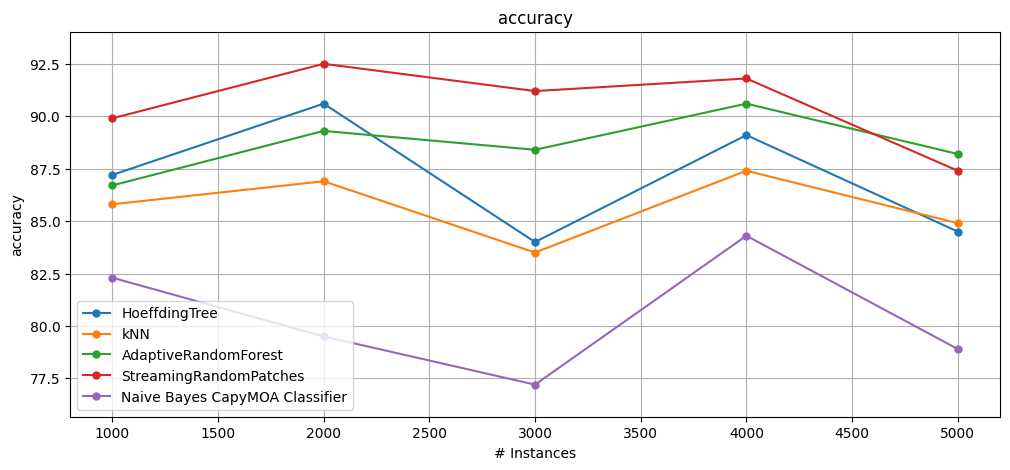

In [5]:
# Code to select the best performing model
schema = stream.get_schema()
ht = HoeffdingTree(schema)
knn = KNN(schema)
arf = AdaptiveRandomForestClassifier(schema, ensemble_size=5)
srp = StreamingRandomPatches(schema, ensemble_size=5)
nb = NaiveBayes(schema)
model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, 1000, 5000)
plot_windowed_results(*all_res.values(), metric="accuracy")

## 9.2 AutoML

The following example shows how to use the AutoClass algorithm using CapyMOA.

* ``base_classifiers`` is a list of classifier class types that will be candidates
  for the AutoML algorithm. The AutoML algorithm will select the best classifier
  based on its performance on the stream.

* ``configuration_json`` is a json file that contains the configuration for the
  AutoML algorithm. An example of the configuration file is shown below:


*Maroua Bahri, Nikolaos Georgantas. Autoclass: Automl for data stream
classification. In BigData, IEEE, 2023. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10386362*

In [10]:
with open("./settings_autoclass.json", "r") as f:
    settings = f.read()
    print(settings)

{

  "windowSize" :  1000,
  "ensembleSize" : 10,
  "newConfigurations" : 10,
  "keepCurrentModel" : true,
  "lambda" : 0.05,
  "preventAlgorithmDeath" : true,
  "keepGlobalIncumbent" : true,
  "keepAlgorithmIncumbents" : true,
  "keepInitialConfigurations" : true,
  "useTestEnsemble" : true,
  "resetProbability" : 0.01,
  "numberOfCores" : 1,
  "performanceMeasureMaximisation": true,

  "algorithms": [
    {
      "algorithm": "moa.classifiers.lazy.kNN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.trees.HoeffdingTree",
      "parameters": [
        {"parameter": "g", "type":"integer", "value":200, "range":[10, 200]},
       {"parameter": "c", "type":"float", "value":0.01, "range":[0, 1]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.lazy.kNNwithPAWandADWIN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
  

In [11]:
from capymoa.automl import AutoClass

max_instances = 20000
window_size = 2500

schema = stream.get_schema()
autoclass = AutoClass(
    schema=schema,
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)
results_autoclass = prequential_evaluation(
    stream=stream,
    learner=autoclass,
    window_size=window_size,
    max_instances=max_instances,
)
print_summary("AutoClass", results_autoclass)

AutoClass  Cumulative accuracy = 88.54, wall-clock time: 32.720


We compare the performance of the AutoML algorithm against basic
classifiers:

HT         Cumulative accuracy = 85.61, wall-clock time: 0.293
HAT        Cumulative accuracy = 87.08, wall-clock time: 0.207
KNN        Cumulative accuracy = 85.47, wall-clock time: 1.893
NB         Cumulative accuracy = 77.23, wall-clock time: 0.169


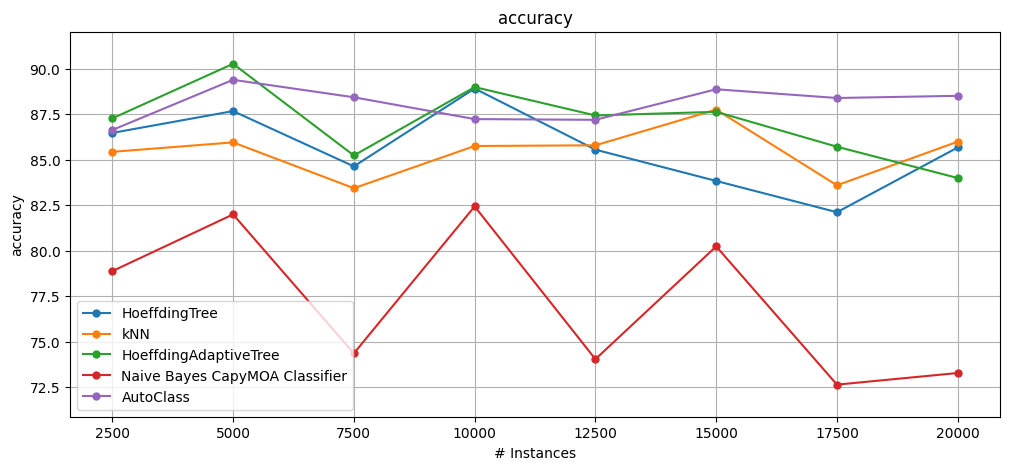

In [8]:
ht = HoeffdingTree(schema)
hat = HoeffdingAdaptiveTree(schema)
knn = KNN(schema)
nb = NaiveBayes(schema)

results_ht = prequential_evaluation(
    stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    stream, nb, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## 9.3 AutoML with Concept Drift

We test the same algorithms on a data stream with simulated concept drift:

HT         Cumulative accuracy = 78.82, wall-clock time: 0.316
HAT        Cumulative accuracy = 78.24, wall-clock time: 0.287
KNN        Cumulative accuracy = 67.14, wall-clock time: 5.484
NB         Cumulative accuracy = 60.29, wall-clock time: 0.114
AutoClass  Cumulative accuracy = 85.27, wall-clock time: 74.773


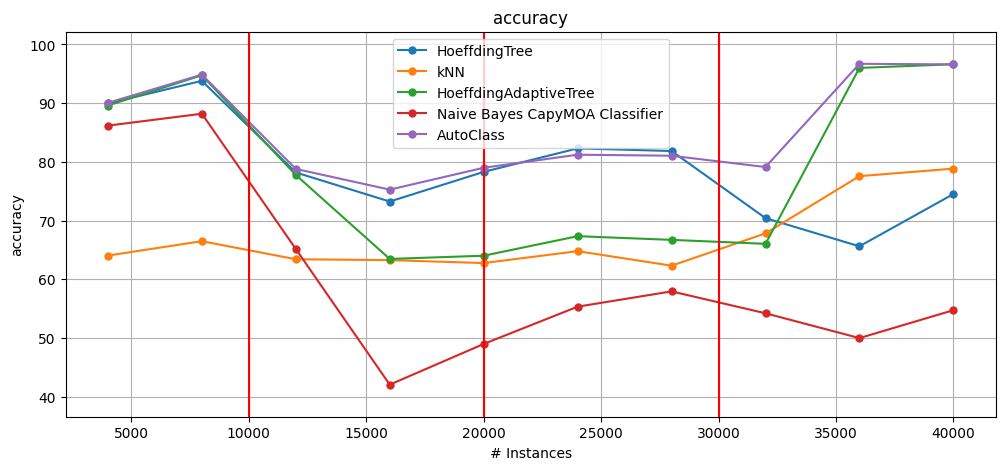

In [9]:
from capymoa.evaluation import prequential_evaluation
from capymoa.automl import AutoClass

max_instances = 40000
window_size = 4000

ht = HoeffdingTree(schema=drift_stream.get_schema())
hat = HoeffdingAdaptiveTree(schema=drift_stream.get_schema())
knn = KNN(schema=drift_stream.get_schema())
nb = NaiveBayes(schema=drift_stream.get_schema())
autoclass = AutoClass(
    schema=drift_stream.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)

results_ht = prequential_evaluation(
    drift_stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    drift_stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    drift_stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    drift_stream, nb, window_size=window_size, max_instances=max_instances
)
results_autoclass = prequential_evaluation(
    drift_stream, autoclass, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
print_summary("AutoClass", results_autoclass)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## 9.4 Comparing different models with SuccessiveHalvingClassifier and BanditClassifier

In [8]:
import json

def test_base_classifiers(stream, max_instances=20000, window_size=2500, bandit_eps=0.3):
    """Test the base_classifiers parameter of SuccessiveHalvingClassifier and BanditClassifier."""
    print("\n" + "="*80)
    print("TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIERS WITH DIRECT BASE_CLASSIFIERS")
    print("="*80)

    schema = stream.get_schema()

    # Create base classifiers with different hyperparameters
    base_models = []

    # Add Hoeffding Trees with different hyperparameters (reduced configurations)
    for grace_period in [100, 200]:
        for confidence in [0.01, 0.1]:
            base_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence))

    # Add KNN variations (reduced configurations)
    for k in [3, 10]:
        base_models.append(KNN(schema=schema, k=k))

    # Add Naive Bayes
    base_models.append(NaiveBayes(schema=schema))

    # Add Random Forest models (reduced configurations)
    for ensemble_size in [80, 100, 120]:
        base_models.append(AdaptiveRandomForestClassifier(schema=schema, ensemble_size=ensemble_size))

    # Add Hoeffding Adaptive Trees (reduced configurations)
    for grace_period in [100, 200]:
        base_models.append(HoeffdingAdaptiveTree(schema=schema, grace_period=grace_period))

    # Add one instance of each other model type
    base_models.append(LeveragingBagging(schema=schema, ensemble_size=80))
    base_models.append(StreamingRandomPatches(schema=schema, ensemble_size=80))
    base_models.append(SGDClassifier(schema=schema))
    base_models.append(PassiveAggressiveClassifier(schema=schema))

    print(f"Total number of model configurations: {len(base_models)}")

    # Create the SuccessiveHalvingClassifier with direct specification of base classifiers
    shc_direct = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=base_models,
        budget=max_instances*3,
        eta=2.0,
        min_models=2,
        verbose=True
    )

    # Create the BanditClassifier with the same base classifiers
    bandit_clf = BanditClassifier(
        schema=schema,
        base_classifiers=base_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Initialize default models for comparison
    print("\nInitializing default models for comparison...")
    default_ht = HoeffdingTree(schema=schema)
    default_nb = NaiveBayes(schema=schema)
    default_knn = KNN(schema=schema)
    default_arf = AdaptiveRandomForestClassifier(schema=schema)
    default_hat = HoeffdingAdaptiveTree(schema=schema)
    default_lb = LeveragingBagging(schema=schema)
    default_srp = StreamingRandomPatches(schema=schema)
    default_sgd = SGDClassifier(schema=schema)
    default_pa = PassiveAggressiveClassifier(schema=schema)

    autoclass = AutoClass(
        schema=schema,
        configuration_json="./settings_autoclass.json",
        base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
    )

    print("\nRunning prequential evaluation...")
    results_shc_direct = prequential_evaluation(
        stream=stream,
        learner=shc_direct,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit = prequential_evaluation(
        stream=stream,
        learner=bandit_clf,
        window_size=window_size,
        max_instances=max_instances
    )

    # Evaluate default models
    print("\nEvaluating default models...")
    results_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_nb = prequential_evaluation(
        stream=stream,
        learner=default_nb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_knn = prequential_evaluation(
        stream=stream,
        learner=default_knn,
        window_size=window_size,
        max_instances=max_instances
    )

    results_arf = prequential_evaluation(
        stream=stream,
        learner=default_arf,
        window_size=window_size,
        max_instances=max_instances
    )

    results_hat = prequential_evaluation(
        stream=stream,
        learner=default_hat,
        window_size=window_size,
        max_instances=max_instances
    )

    results_lb = prequential_evaluation(
        stream=stream,
        learner=default_lb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_srp = prequential_evaluation(
        stream=stream,
        learner=default_srp,
        window_size=window_size,
        max_instances=max_instances
    )

    results_sgd = prequential_evaluation(
        stream=stream,
        learner=default_sgd,
        window_size=window_size,
        max_instances=max_instances
    )

    results_pa = prequential_evaluation(
        stream=stream,
        learner=default_pa,
        window_size=window_size,
        max_instances=max_instances
    )

    results_autoclass = prequential_evaluation(
        stream=stream,
        learner=autoclass,
        window_size=window_size,
        max_instances=max_instances,
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[Successive Halving with {len(base_models)} base models] Accuracy = {results_shc_direct.accuracy():.3f}, "
          f"Time: {results_shc_direct.wallclock():.3f}s")
    print(f"[Bandit Classifier with {len(base_models)} base models] Accuracy = {results_bandit.accuracy():.3f}, "
          f"Time: {results_bandit.wallclock():.3f}s")
    print(f"[AutoClass] Accuracy = {results_autoclass.accuracy():.3f}, "
          f"Time: {results_autoclass.wallclock():.3f}s")
    print(f"[Default Hoeffding Tree] Accuracy = {results_ht.accuracy():.3f}, "
          f"Time: {results_ht.wallclock():.3f}s")
    print(f"[Default Naive Bayes] Accuracy = {results_nb.accuracy():.3f}, "
          f"Time: {results_nb.wallclock():.3f}s")
    print(f"[Default KNN] Accuracy = {results_knn.accuracy():.3f}, "
          f"Time: {results_knn.wallclock():.3f}s")
    print(f"[Default Adaptive Random Forest] Accuracy = {results_arf.accuracy():.3f}, "
          f"Time: {results_arf.wallclock():.3f}s")
    print(f"[Default Hoeffding Adaptive Tree] Accuracy = {results_hat.accuracy():.3f}, "
          f"Time: {results_hat.wallclock():.3f}s")
    print(f"[Default Leverage Bagging] Accuracy = {results_lb.accuracy():.3f}, "
          f"Time: {results_lb.wallclock():.3f}s")
    print(f"[Default Streaming Random Patches] Accuracy = {results_srp.accuracy():.3f}, "
          f"Time: {results_srp.wallclock():.3f}s")

    # Plot results
    print("\nPlotting windowed results...")
    plot_windowed_results(
        results_shc_direct, results_bandit, results_autoclass, results_ht, results_nb,
        results_knn, results_arf, results_hat, results_lb, results_srp, results_sgd,
        results_pa, metric="accuracy"
    )

    # Display final model info for SuccessiveHalving
    model_info_shc = shc_direct.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")
    print(f"Best model accuracy: {model_info_shc['best_model_accuracy']:.4f}")

    # # Display final model info for BanditClassifier
    # model_info_bandit = bandit_clf.get_model_info()
    # print("\nBandit Classifier Final Status:")
    # print(f"Total models: {model_info_bandit['total_models']}")
    # print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")
    # print("\nTop performing models in BanditClassifier:")
    # for i, model_info in enumerate(model_info_bandit['top_models']):
    #     print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    return (results_shc_direct, results_bandit, results_autoclass, results_ht,
            results_nb, results_knn, results_arf, results_hat, results_lb,
            results_srp, results_sgd, results_pa)

def test_successive_halving_parameter_tuning(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Test SuccessiveHalving and BanditClassifier for parameter optimization of a single model type."""
    print("\n" + "="*80)
    print("TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 2

    # Create a wide range of HoeffdingTree configurations with different parameters
    ht_models = []

    # Test different grace periods
    for grace_period in [50, 100, 200, 300, 400]:
        # Test different split confidences
        for confidence in [0.001, 0.01, 0.05, 0.1, 0.2]:
            # Test different tie thresholds
            for tie_threshold in [0.05, 0.1, 0.2]:
                ht_models.append(HoeffdingTree(
                    schema=schema,
                    grace_period=grace_period,
                    confidence=confidence,
                    tie_threshold=tie_threshold
                ))

    print(f"Created {len(ht_models)} different HoeffdingTree configurations")

    # Use SuccessiveHalving to find the best HoeffdingTree configuration
    shc_ht = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=ht_models,
        budget=budget,
        eta=2.0,
        min_models=1,
        verbose=True
    )

    # Use BanditClassifier to find the best HoeffdingTree configuration
    bandit_ht = BanditClassifier(
        schema=schema,
        base_classifiers=ht_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Default HoeffdingTree for comparison
    default_ht = HoeffdingTree(schema=schema)

    print("\nRunning prequential evaluation...")
    results_shc_ht = prequential_evaluation(
        stream=stream,
        learner=shc_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit_ht = prequential_evaluation(
        stream=stream,
        learner=bandit_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_default_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[SuccessiveHalving with {len(ht_models)} HT configs] Accuracy = {results_shc_ht.accuracy():.3f}, "
          f"Time: {results_shc_ht.wallclock():.3f}s")
    print(f"[BanditClassifier with {len(ht_models)} HT configs] Accuracy = {results_bandit_ht.accuracy():.3f}, "
          f"Time: {results_bandit_ht.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_default_ht.accuracy():.3f}, "
          f"Time: {results_default_ht.wallclock():.3f}s")

    # Calculate improvements
    improvement_shc = (results_shc_ht.accuracy() - results_default_ht.accuracy())
    improvement_bandit = (results_bandit_ht.accuracy() - results_default_ht.accuracy())
    print(f"Improvement over default parameters:")
    print(f"  SuccessiveHalving: {improvement_shc:.2f}% absolute")
    print(f"  BanditClassifier: {improvement_bandit:.2f}% absolute")

    # Plot results
    plot_windowed_results(
        results_shc_ht, results_bandit_ht, results_default_ht,
        metric="accuracy"
    )

    # Display final model info
    model_info_shc = shc_ht.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")

    # model_info_bandit = bandit_ht.get_model_info()
    # print("\nBandit Classifier Final Status:")
    # print(f"Total models: {model_info_bandit['total_models']}")
    # print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")

    return results_shc_ht, results_bandit_ht, results_default_ht, shc_ht, bandit_ht

def create_extended_autoclass_config():
    """Create an extended configuration for AutoClass with more models and parameters."""
    # Create the configuration similar to the models in test_base_classifiers
    enhanced_conf = {
        "ensembleSize": 10,
        "newConfigurations": 10,
        "keepCurrentModel": True,
        "lambda": 0.05,
        "preventAlgorithmDeath": True,
        "keepGlobalIncumbent": True,
        "keepAlgorithmIncumbents": True,
        "keepInitialConfigurations": True,
        "useTestEnsemble": True,
        "resetProbability": 0.01,
        "numberOfCores": 1,
        "performanceMeasureMaximisation": True,

        "algorithms": [
            {
                "algorithm": "moa.classifiers.trees.HoeffdingTree",
                "parameters": [
                    {"parameter": "g", "type": "integer", "value": 200, "range": [100, 400]},
                    {"parameter": "c", "type": "float", "value": 0.01, "range": [0.001, 0.1]}
                ]
            },
            {
                "algorithm": "moa.classifiers.lazy.kNN",
                "parameters": [
                    {"parameter": "k", "type": "integer", "value": 10, "range": [3, 20]}
                ]
            },
            # {
            #     "algorithm": "moa.classifiers.bayes.NaiveBayes",
            #     "parameters": []
            # },
            {
                "algorithm": "moa.classifiers.meta.AdaptiveRandomForest",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 100, "range": [80, 120]}
                ]
            },
            {
                "algorithm": "moa.classifiers.trees.HoeffdingAdaptiveTree",
                "parameters": [
                    {"parameter": "g", "type": "integer", "value": 200, "range": [100, 300]}
                ]
            },
            {
                "algorithm": "moa.classifiers.meta.LeveragingBag",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 80, "range": [60, 100]}
                ]
            },
            {
                "algorithm": "moa.classifiers.meta.StreamingRandomPatches",
                "parameters": [
                    {"parameter": "s", "type": "integer", "value": 80, "range": [60, 100]}
                ]
            },
            # {
            #     "algorithm": "moa.classifiers.functions.SGD",
            #     "parameters": []
            # },
            # {
            #     "algorithm": "moa.classifiers.functions.PassiveAggressive",
            #     "parameters": []
            # }
        ]
    }

    # Save the configuration to a file
    with open('enhanced_autoclass_config.json', 'w') as fp:
        json.dump(enhanced_conf, fp)

    print("Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'")
    return 'enhanced_autoclass_config.json'

def test_autoclass_vs_successive_halving(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Compare AutoClass with enhanced configuration against SuccessiveHalvingClassifier and BanditClassifier."""
    print("\n" + "="*80)
    print("COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 3

    # Create the enhanced configuration for AutoClass
    enhanced_config_file = create_extended_autoclass_config()

    # Initialize AutoClass with the enhanced configuration
    autoclass_enhanced = AutoClass(
        schema=schema,
        configuration_json=enhanced_config_file,
        base_classifiers=[KNN, HoeffdingTree, HoeffdingAdaptiveTree, AdaptiveRandomForestClassifier,
                         LeveragingBagging, StreamingRandomPatches]
    )

    # Create base classifiers with same parameters for SuccessiveHalving and BanditClassifier
    base_models = []

    # Add Hoeffding Trees
    for grace_period in [100, 200, 300, 400]:
        for confidence in [0.001, 0.01, 0.05, 0.1]:
            base_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence))

    # Add KNN variations
    for k in [3, 5, 10, 15, 20]:
        base_models.append(KNN(schema=schema, k=k))

    # Add Random Forest models
    for ensemble_size in [80, 100, 120]:
        base_models.append(AdaptiveRandomForestClassifier(schema=schema, ensemble_size=ensemble_size))

    # Add Hoeffding Adaptive Trees
    for grace_period in [100, 200, 300]:
        base_models.append(HoeffdingAdaptiveTree(schema=schema, grace_period=grace_period))

    # Add Leveraging Bagging models
    for ensemble_size in [60, 80, 100]:
        base_models.append(LeveragingBagging(schema=schema, ensemble_size=ensemble_size))

    # Add Streaming Random Patches
    for ensemble_size in [60, 80, 100]:
        base_models.append(StreamingRandomPatches(schema=schema, ensemble_size=ensemble_size))

    print(f"Total number of model configurations: {len(base_models)}")

    # Create the SuccessiveHalvingClassifier
    shc_direct = SuccessiveHalvingClassifier(
        schema=schema,
        base_classifiers=base_models,
        budget=budget,
        eta=2.0,
        min_models=2,
        verbose=True
    )

    # Create the BanditClassifier
    bandit_clf = BanditClassifier(
        schema=schema,
        base_classifiers=base_models,
        metric="accuracy",
        policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150),
        verbose=True
    )

    # Initialize default models for comparison
    print("\nInitializing default models for comparison...")
    default_ht = HoeffdingTree(schema=schema)
    default_knn = KNN(schema=schema)
    default_arf = AdaptiveRandomForestClassifier(schema=schema)
    default_hat = HoeffdingAdaptiveTree(schema=schema)
    default_lb = LeveragingBagging(schema=schema)
    default_srp = StreamingRandomPatches(schema=schema)

    print("\nRunning prequential evaluation...")

    # Evaluate all approaches
    results_autoclass_enhanced = prequential_evaluation(
        stream=stream,
        learner=autoclass_enhanced,
        window_size=window_size,
        max_instances=max_instances
    )

    results_shc = prequential_evaluation(
        stream=stream,
        learner=shc_direct,
        window_size=window_size,
        max_instances=max_instances
    )

    results_bandit = prequential_evaluation(
        stream=stream,
        learner=bandit_clf,
        window_size=window_size,
        max_instances=max_instances
    )

    # Evaluate default models
    print("\nEvaluating default models...")
    results_ht = prequential_evaluation(
        stream=stream,
        learner=default_ht,
        window_size=window_size,
        max_instances=max_instances
    )

    results_knn = prequential_evaluation(
        stream=stream,
        learner=default_knn,
        window_size=window_size,
        max_instances=max_instances
    )

    results_arf = prequential_evaluation(
        stream=stream,
        learner=default_arf,
        window_size=window_size,
        max_instances=max_instances
    )

    results_hat = prequential_evaluation(
        stream=stream,
        learner=default_hat,
        window_size=window_size,
        max_instances=max_instances
    )

    results_lb = prequential_evaluation(
        stream=stream,
        learner=default_lb,
        window_size=window_size,
        max_instances=max_instances
    )

    results_srp = prequential_evaluation(
        stream=stream,
        learner=default_srp,
        window_size=window_size,
        max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[Enhanced AutoClass] Accuracy = {results_autoclass_enhanced.accuracy():.3f}, "
          f"Time: {results_autoclass_enhanced.wallclock():.3f}s")
    print(f"[SuccessiveHalving] Accuracy = {results_shc.accuracy():.3f}, "
          f"Time: {results_shc.wallclock():.3f}s")
    print(f"[BanditClassifier] Accuracy = {results_bandit.accuracy():.3f}, "
          f"Time: {results_bandit.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_ht.accuracy():.3f}, "
          f"Time: {results_ht.wallclock():.3f}s")
    print(f"[Default KNN] Accuracy = {results_knn.accuracy():.3f}, "
          f"Time: {results_knn.wallclock():.3f}s")
    print(f"[Default AdaptiveRandomForest] Accuracy = {results_arf.accuracy():.3f}, "
          f"Time: {results_arf.wallclock():.3f}s")
    print(f"[Default HoeffdingAdaptiveTree] Accuracy = {results_hat.accuracy():.3f}, "
          f"Time: {results_hat.wallclock():.3f}s")
    print(f"[Default LeveragingBagging] Accuracy = {results_lb.accuracy():.3f}, "
          f"Time: {results_lb.wallclock():.3f}s")
    print(f"[Default StreamingRandomPatches] Accuracy = {results_srp.accuracy():.3f}, "
          f"Time: {results_srp.wallclock():.3f}s")

    # Plot results
    plot_windowed_results(
        results_autoclass_enhanced, results_shc, results_bandit, results_ht,
        results_knn, results_arf, results_hat, results_lb, results_srp,
        metric="accuracy"
    )

    # Display final model info for SuccessiveHalving
    model_info_shc = shc_direct.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")

    # Display final model info for BanditClassifier
    model_info_bandit = bandit_clf.get_model_info()
    print("\nBandit Classifier Final Status:")
    print(f"Total models: {model_info_bandit['total_models']}")
    print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")

    print("\nTop performing models:")
    print("SuccessiveHalving:")
    for i, model_info in enumerate(model_info_shc['top_models']):
        print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    # print("\nBanditClassifier:")
    # for i, model_info in enumerate(model_info_bandit['top_models']):
    #     print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

    return (results_autoclass_enhanced, results_shc, results_bandit, results_ht,
            results_knn, results_arf, results_hat, results_lb, results_srp)

### Testing whether SuccessiveHalvingClassifier and BanditClassifier work correctly


TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION
Created 75 different HoeffdingTree configurations
Using 75 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1119df440>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1119dd760>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1013710>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1119a72c0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a01117c0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a17379b0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83b90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83fb0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83f50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83e90>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83ce0>, <capymoa.classifier._ho

(<capymoa.evaluation.results.PrequentialResults at 0x1a0233f80>,
 <capymoa.automl._bandit_classifier.BanditClassifier at 0x1a0110a70>)

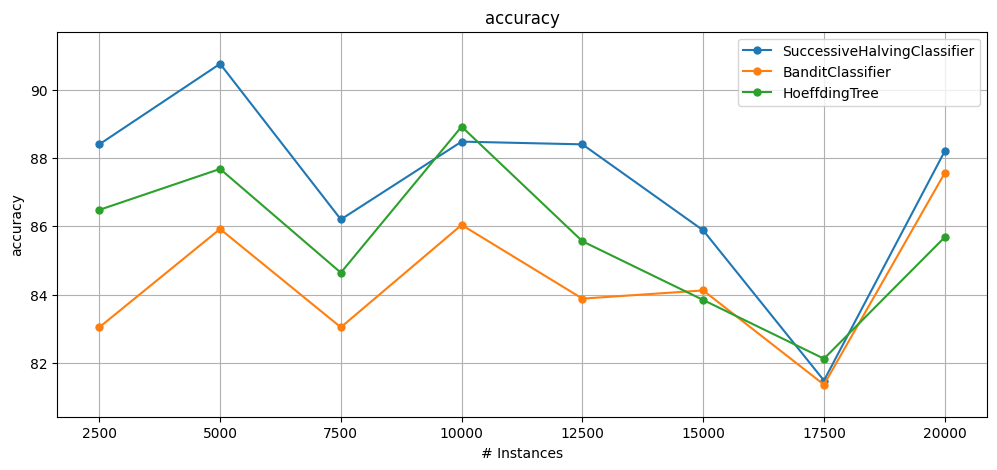

In [6]:
stream = Electricity()
max_instances = 20000
window_size = 2500
budget=max_instances*2
test_successive_halving_parameter_tuning(stream, max_instances=max_instances, window_size=window_size, budget=budget)

The initial test demonstrates that both SuccessiveHalvingClassifier and BanditClassifier work correctly for parameter optimization.

SuccessiveHalvingClassifier achieves the highest accuracy at 87.225%, showing a substantial 1.61% absolute improvement over the default HoeffdingTree. However, this comes at a computational cost of 153.404s. BanditClassifier offers a middle ground, reaching 85.630% accuracy (only 0.02% above default) while requiring significantly less time (85.613s), making it approximately 44% faster than SuccessiveHalvingClassifier.

The accuracy-time trade-off is clear: SuccessiveHalvingClassifier invests more computational resources to thoroughly evaluate configurations, while BanditClassifier makes quicker decisions that sacrifice some accuracy for substantial time savings.

### Comparing Autoclass with SuccessiveHalving and BanditClassifier on Electricity Stream


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2742840>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1c83d70>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c6b40>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c5220>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c4440>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c6900>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c6a20>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c5fd0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c7b60>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c6960>, <capymoa.classifier._hoeffding_t

(<capymoa.evaluation.results.PrequentialResults at 0x1a1f08fe0>,
 <capymoa.evaluation.results.PrequentialResults at 0x1a1d08080>)

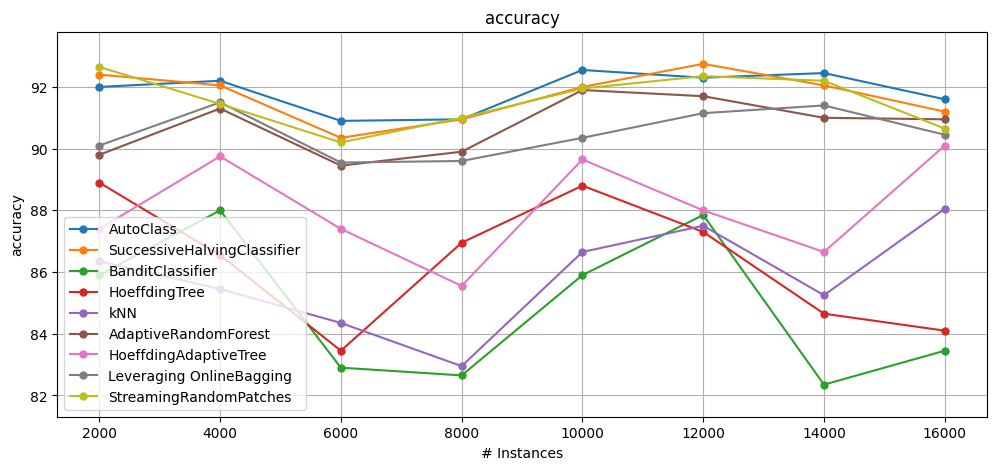

In [14]:
stream = Electricity()
max_instances = 15000
window_size = 2000
budget=max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

On the Electricity dataset, Enhanced AutoClass demonstrates superior accuracy at 91.833%, closely followed by SuccessiveHalvingClassifier at 91.600%. BanditClassifier significantly underperforms with 84.493% accuracy, falling behind even the default HoeffdingTree (86.187%). Regarding computational efficiency, BanditClassifier completes in just 75.419s, compared to 264.252s for SuccessiveHalvingClassifier and 438.069s for Enhanced AutoClass. This represents a stark trade-off where BanditClassifier runs 5.8x faster than AutoClass but sacrifices 7.34% in accuracy.

SuccessiveHalvingClassifier provides an excellent balance, achieving nearly identical accuracy to AutoClass while requiring 40% less time. For this stream, SuccessiveHalvingClassifier clearly outperforms BanditClassifier in the accuracy-efficiency trade-off, suggesting that more thorough configuration exploration is beneficial for this particular data pattern. Both model selection approaches outperform individual default models, except for BanditClassifier which falls behind several default options.

### RBFm_100k Stream

RBFm_100k.arff: 8.62MB [00:01, 5.20MB/s]                            



COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278f110>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278d010>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278c7d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278ed80>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a27497c0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a274a510>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2749790>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a274a270>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2749a00>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a274a2d0>, <capymoa.classifier._hoeffding_t

(<capymoa.evaluation.results.PrequentialResults at 0x1a2043530>,
 <capymoa.evaluation.results.PrequentialResults at 0x1a1ce9820>)

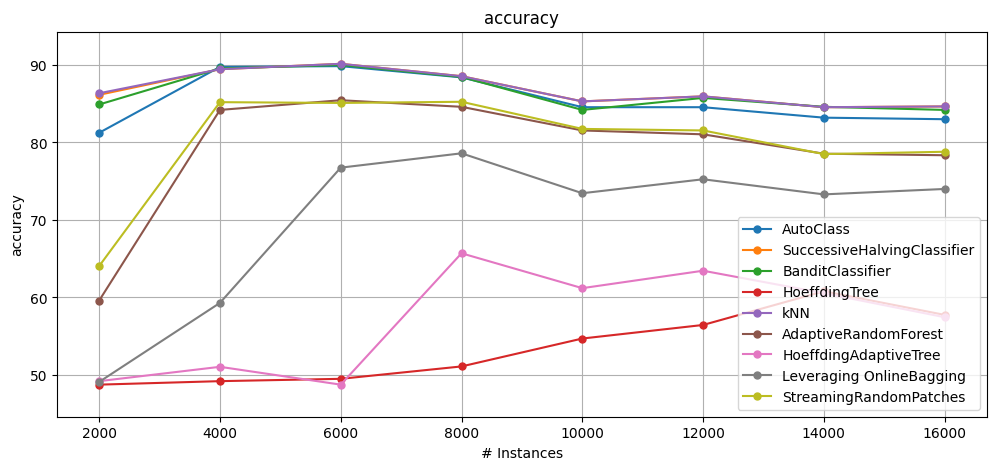

In [17]:
stream = RBFm_100k()
max_instances = 15000
window_size = 2000
budget = max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

The RBFm_100k stream presents a different scenario where SuccessiveHalvingClassifier achieves the highest accuracy at 87.013%, slightly outperforming the default KNN (87.040%) and BanditClassifier (86.787%). Enhanced AutoClass falls behind at 85.427%. Computationally, BanditClassifier completes in 126.094s, approximately half the time of SuccessiveHalvingClassifier (250.490s) and a quarter of Enhanced AutoClass's time (494.321s).

All three methods dramatically outperform the default HoeffdingTree (53.153%), demonstrating the value of parameter optimization on this complex stream. The efficiency-accuracy trade-off is most favorable for SuccessiveHalvingClassifier here, as it achieves the best accuracy while requiring only half the computational resources of AutoClass. BanditClassifier offers a compelling alternative when processing time is critical, sacrificing only 0.23% accuracy compared to SuccessiveHalvingClassifier while running twice as fast.

### Custom stream with drift


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a24e71d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bc7d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bc7a0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278ff50>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a03d7ce0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a278d010>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2606ed0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2606de0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2607140>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2607260>, <capymoa.classifier._hoeffding_t

(<capymoa.evaluation.results.PrequentialResults at 0x1a1707f80>,
 <capymoa.evaluation.results.PrequentialResults at 0x1a1d083e0>)

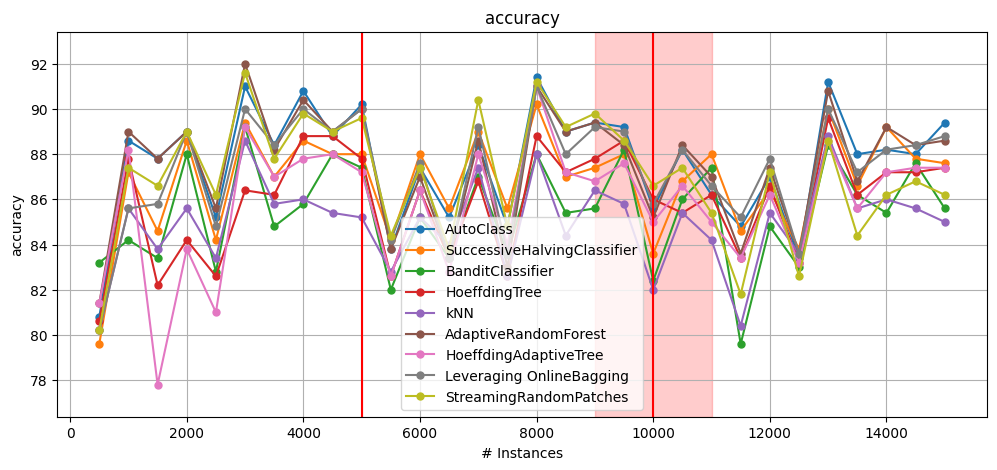

In [18]:
window_size=500
max_instances=15000
budget=max_instances*3
drift_stream = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        SEA(function=1),
    ]
)
test_autoclass_vs_successive_halving(drift_stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

For the custom stream with drift, Enhanced AutoClass achieves the highest accuracy at 87.680%, followed by SuccessiveHalvingClassifier (86.820%) and BanditClassifier (86.113%). All three outperform the default HoeffdingTree (85.933%), though with diminishing returns. The execution times vary significantly: BanditClassifier completes in 83.838s, SuccessiveHalvingClassifier in 178.488s, and Enhanced AutoClass in 226.214s. The accuracy differences between the methods are relatively small (1.57% between highest and lowest), while the computational differences are substantial (AutoClass takes 2.7x longer than BanditClassifier).

On this stream, BanditClassifier offers the most favorable efficiency-accuracy trade-off for time-sensitive applications, as it sacrifices only 0.71% accuracy compared to SuccessiveHalvingClassifier while running more than twice as fast. Among default models, AdaptiveRandomForest performs competitively at 87.500% accuracy, highlighting that sophisticated model selection is not always necessary when certain default models already perform well.

### Custom stream with drift


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Enhanced AutoClass configuration saved to 'enhanced_autoclass_config.json'
Total number of model configurations: 33
Using 33 provided base classifiers
[<capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a1ce89e0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c66c0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25c4fb0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bdb20>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bcce0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bdf70>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a25bc7d0>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2715460>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a2717350>, <capymoa.classifier._hoeffding_tree.HoeffdingTree object at 0x1a27175f0>, <capymoa.classifier._hoeffding_t

(<capymoa.evaluation.results.PrequentialResults at 0x1119dfe00>,
 <capymoa.evaluation.results.PrequentialResults at 0x1a0fe1a60>)

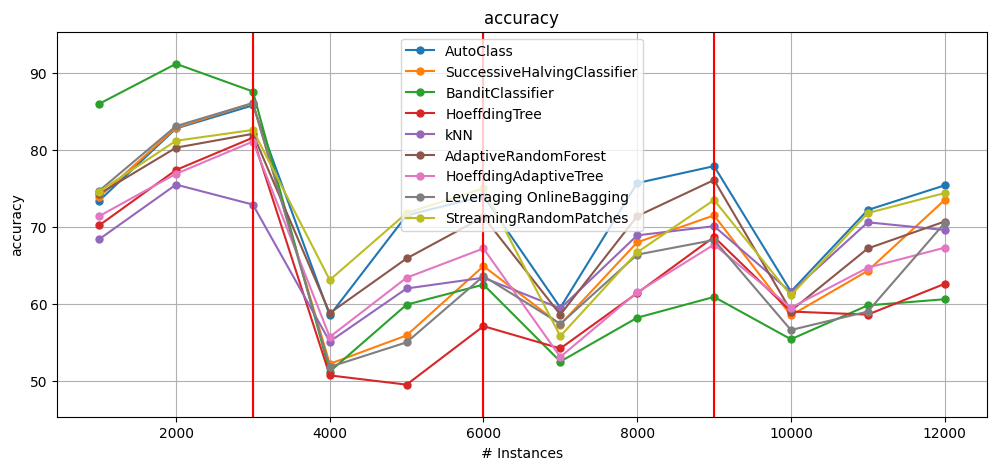

In [19]:
concept_length = 3000
max_instances = concept_length * 4
window_size = 1000

# Create a stream with multiple concept drifts
drift_stream = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=concept_length),
        RandomTreeGenerator(tree_random_seed=2),
        AbruptDrift(position=concept_length * 2),
        RandomTreeGenerator(tree_random_seed=3),
        AbruptDrift(position=concept_length * 3),
        RandomTreeGenerator(tree_random_seed=4),
    ]
)

test_autoclass_vs_successive_halving(drift_stream, max_instances, window_size, budget=max_instances*3, bandit_eps=0.3)

On the challenging custom stream with concept drift, Enhanced AutoClass clearly outperforms with 72.100% accuracy, compared to SuccessiveHalvingClassifier (67.417%) and BanditClassifier (66.817%). The computational requirements vary dramatically: BanditClassifier completes in 105.817s, SuccessiveHalvingClassifier in 213.327s, and Enhanced AutoClass in 776.176s. The accuracy gap of 5.28% between AutoClass and SuccessiveHalvingClassifier, coupled with AutoClass taking 3.6x longer, presents a significant trade-off decision.

BanditClassifier and SuccessiveHalvingClassifier achieve similar accuracies (difference of only 0.6%), with BanditClassifier being twice as fast. This suggests that in concept drift scenarios, Enhanced AutoClass's thorough approach to model selection provides substantial benefits for accuracy, albeit at a high computational cost. Among default models, StreamingRandomPatches performs relatively well (70.967%), indicating that ensemble methods may be particularly suited for concept drift.

### Overall Analysis

Across all tested streams, the three model selection approaches demonstrate consistent patterns in their accuracy-efficiency trade-offs:

AutoClass consistently delivers the highest or near-highest accuracy (except on RBFm_100k) but requires substantially more computational resources, with processing times typically 2-7x longer than BanditClassifier. It excels particularly in challenging scenarios with concept drift, where thorough exploration of the model space proves valuable.

SuccessiveHalvingClassifier offers a balanced middle ground, typically achieving accuracy within 0.5-5% of Enhanced AutoClass while requiring 40-70% less processing time. It performs particularly well on the Electricity and RBFm_100k streams, where it matches or exceeds AutoClass's accuracy at a fraction of the computational cost.

BanditClassifier prioritizes computational efficiency, running approximately 40-50% faster than SuccessiveHalvingClassifier and 70-85% faster than Enhanced AutoClass across all streams. However, this comes at an accuracy cost, typically 0.2-7% below the best-performing method. BanditClassifier struggles particularly on the Electricity stream but performs competitively on RBFm_100k and streams with mild drift.

The effectiveness of these approaches relative to default models varies by stream. On streams where default models already perform well (e.g., custom stream with drift where AdaptiveRandomForest achieves 87.500%), the benefits of sophisticated model selection are marginal. However, on more challenging streams like RBFm_100k, where default models struggle significantly, all three selection methods provide substantial improvements.

These results suggest that the choice between these approaches should be guided by the specific application requirements:

1. For applications where maximizing accuracy is critical and computational resources are available, Enhanced AutoClass is preferable.

2. For scenarios requiring a balance between accuracy and efficiency, SuccessiveHalvingClassifier offers the best compromise.

3. For time-sensitive or resource-constrained applications, BanditClassifier provides reasonable accuracy improvements with minimal computational overhead.

The consistent performance patterns across diverse streams demonstrate that these model selection approaches provide valuable alternatives for different computational budgets and accuracy requirements in stream learning environments